In [3]:
import matplotlib.pyplot as plt

In [4]:
def sort_num(img_path_ls):
    # 桁数の異なる数字を名前に持つファイルの並び替え
    # ~/img1.bmp, ~/img100.bmp
    sorted_ls = [""] * len(img_ls)

    for path in img_path_ls:

        id_ = path.split("img")[1].split(".")[0] 

        sorted_ls[int(id_)] = path

    return sorted_ls


def 画像処理の関数

In [5]:
# 画像処理
def img_preprocessing(img):
    from skimage import color, filters, util
    plt.rcParams["image.cmap"] = "gray"

    # gray
    img_gray = color.rgb2gray(img)

    # 二値化
    thres = filters.threshold_otsu(img_gray)
    img_bin = img_gray > thres

    # edge 検知
    img_temp = filters.sobel(img_gray)
    img_sob = util.invert(img_temp)

    # fill hole
    def fill_holes_erosion_dilation(img_bin):
        from scipy.ndimage.morphology import binary_fill_holes
        from skimage.morphology import erosion, dilation

        img_fill_holes = util.invert(img_bin)
        img_fill_holes = binary_fill_holes(img_fill_holes).astype(int)
        img_fill_holes = util.invert(img_fill_holes)

        # erosion
        eroded = erosion(img_fill_holes)
        for i in range(3):
            eroded = erosion(eroded)

        # dilation
        dilated = dilation(eroded)
        for i in range(3):
            dilated = dilation(dilated)
        dilated = util.invert(dilated)
        dilated = binary_fill_holes(dilated).astype(int)
        return dilated

    dilated = fill_holes_erosion_dilation(img_bin)
    
    return img_sob, img_gray, img_bin, dilated


In [6]:
def show_imgs(i, img, img_sob, img_gray, img_bin, dilated):
    plt.figure(figsize=(8, 8))

    plt.subplot(221)
    plt.title("sauce:" + str(i))
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(222)
    plt.title("edge:sob")
    plt.imshow(img_sob)
    #plt.imshow(img_gray)
    plt.axis("off")

    plt.subplot(223)
    plt.title("binary")
    plt.imshow(img_bin)
    plt.axis("off")

    plt.subplot(224)
    plt.title("fill hole")
    plt.imshow(dilated)
    plt.axis("off")

    plt.show()


### 輪郭検出

In [7]:
from skimage import measure
import cv2
from skimage.measure import label, regionprops
def show_contour(img):

    def guess_maxlen_contour(contours):
        "最大長の輪郭線をもつオブジェクトを線虫と推定"
        return sorted(contours, key=len, reverse=True)[0]
    def center_position(contour):
        mu = cv2.moments(contour)
        cx, cy = int(mu["m10"]/mu["m00"]) , int(mu["m01"]/mu["m00"])
        return cx, cy

    # Find contours at a constant value of 0.8
    contours = measure.find_contours(img, 0.8)

    # Display the image and plot all contours found
    plt.imshow(img, interpolation='nearest')

    contour = guess_maxlen_contour(contours)
    cx, cy = center_position(contour)
    print(cx, cy)

    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

    plt.scatter(cx, cy, s=5)

    plt.axis('image')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    return contours


### 線虫部分のみ切り取り

In [53]:
import matplotlib.patches as mpatches
from skimage.measure import label, regionprops

def labeling(img):
    def get_largest_region(regions):
        tmp_area = 0
        for region in regions:
            tmp_area = max(region.area, tmp_area)
        for region in regions:
            if tmp_area == region.area:
                return region

    # label image regions
    label_image = label(img)

    # take regions with largest enough areas
    regions = regionprops(label_image)
    region = get_largest_region(regions)

    img = delete_obect_in_largest_region(img, region, regions)

    # cut img
    minr, minc, maxr, maxc = region.bbox
    labeled_img = img[minr:maxr, minc:maxc]

    # detect on edge
    labeled_img = check_whether_on_edge(img, labeled_img, region)

    return labeled_img

def show_img(img):
    plt.imshow(img)
    plt.axis("off")
    plt.show()



In [58]:
from skimage.util import pad
def padding(img):
    x_width = (500 - img.shape[0]) // 2
    y_width = (500 - img.shape[1]) // 2
    x_width_up = x_width
    y_width_up = y_width
    if img.shape[0] % 2 == 1:
        x_width_up += 1
    if img.shape[1] % 2 == 1:
        y_width_up += 1
    img_padded = pad(img, [(x_width_up, x_width), (y_width_up, y_width)], mode="constant")
    return img_padded

## Path取得

In [10]:
# Read
import glob
dir_ls = glob.glob("F:\Tanimoto_eLife_Fig3B\*")

# sample_dir_path = dir_ls[0]
sample_img_path = []

# 見切れてる画像
sample_dir_path = "F:\\Tanimoto_eLife_Fig3B\\201302111435"
img_ls = glob.glob(sample_dir_path + "/main/*")
img_ls = sort_num(img_ls)
sample_img_path.append(img_ls[0])

# とぐろ画像
sample_dir_path = "F:\\Tanimoto_eLife_Fig3B\\201302111542"
img_ls = glob.glob(sample_dir_path + "/main/*")
img_ls = sort_num(img_ls)
sample_img_path.append(img_ls[2319])

# ゴミ映り込み画像
sample_dir_path = "F:\\Tanimoto_eLife_Fig3B\\201302111624"
img_ls = glob.glob(sample_dir_path + "/main/*")
img_ls = sort_num(img_ls)
sample_img_path.append(img_ls[723])

# ゴミ映り込み画像
sample_dir_path = "F:\\Tanimoto_eLife_Fig3B\\201302081425"
img_ls = glob.glob(sample_dir_path + "/main/*")
img_ls = sort_num(img_ls)
sample_img_path.append(img_ls[1674])

# 足跡濃いめ画像
sample_dir_path = "F:\\Tanimoto_eLife_Fig3B\\201302081515"
img_ls = glob.glob(sample_dir_path + "/main/*")
img_ls = sort_num(img_ls)
sample_img_path.append(img_ls[3268])

# とぐろ画像
sample_dir_path = "F:\\Tanimoto_eLife_Fig3B\\201302081530"
img_ls = glob.glob(sample_dir_path + "/main/*")
img_ls = sort_num(img_ls)
sample_img_path.append(img_ls[2861])

# to 201302111352

#del img_ls, dir_ls

## 前処理結果

C:\Users\u853337i\AppData\Local\conda\conda\envs\worm2vec\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
C:\Users\u853337i\AppData\Local\conda\conda\envs\worm2vec\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See https://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


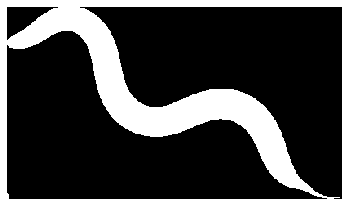

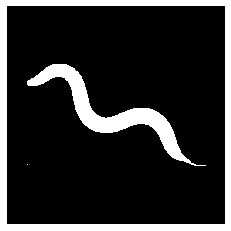

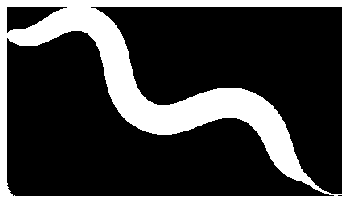

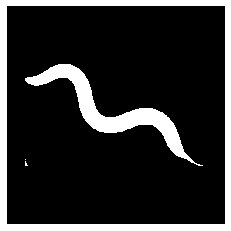

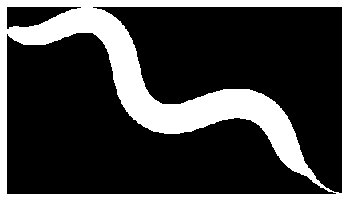

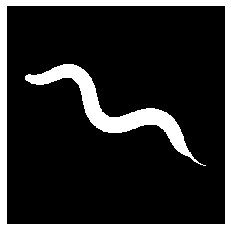

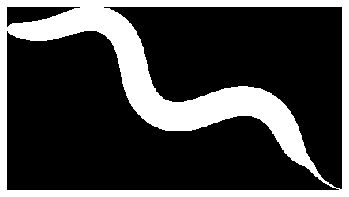

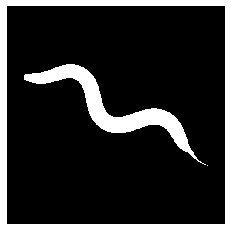

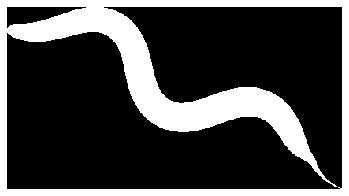

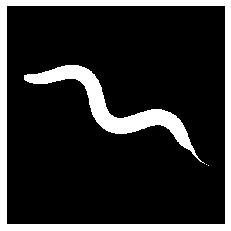

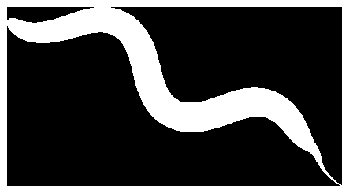

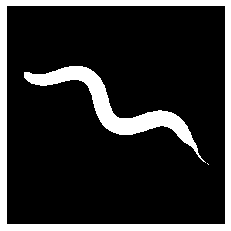

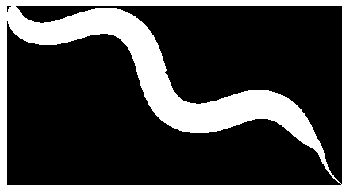

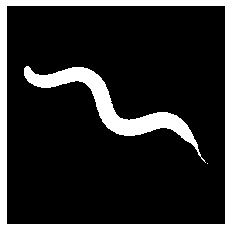

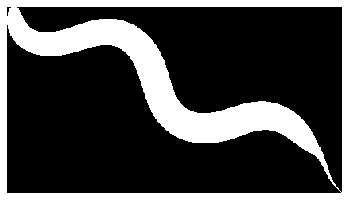

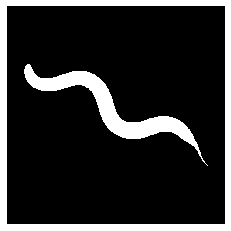

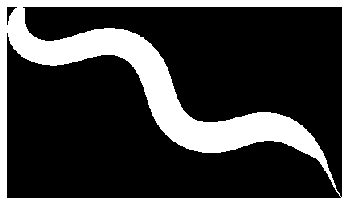

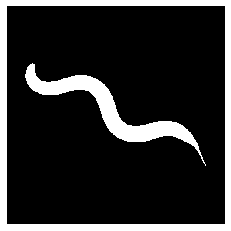

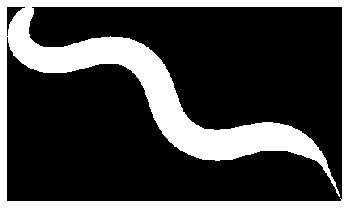

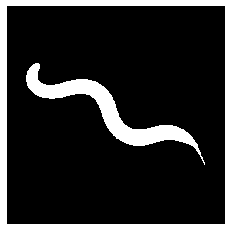

In [59]:
# dir_ls[0]の画像
from skimage import data
img_shapex = []
img_shapey = []
for i, img_path in enumerate(img_ls):
    if i < 10:
        img = data.imread(img_path)
        img_sob, img_gray, img_bin, dilated = img_preprocessing(img)
        #show_imgs(i, img, img_sob, img_gray, img_bin, dilated)
        #contours = show_contour(dilated)

        labeled_img = labeling(dilated)
        show_img(labeled_img)

        padded_img = padding(labeled_img)
        show_img(padded_img)

        img_shapex.append(padded_img.shape[0])
        img_shapey.append(padded_img.shape[1])
        #break
#del img, img_sob, img_gray, img_bin, dilated

### Bounding Box

In [33]:
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
import numpy as np

(328.10324802484973, 373.9557701397799)


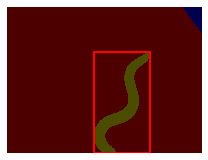

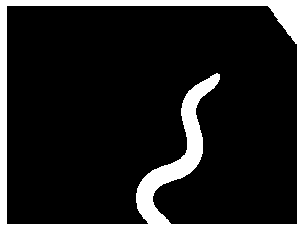

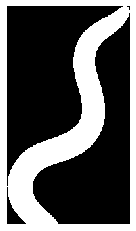

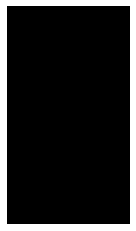

(234.86043435890298, 328.3254907420298)


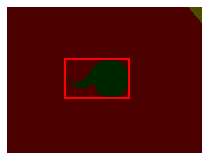

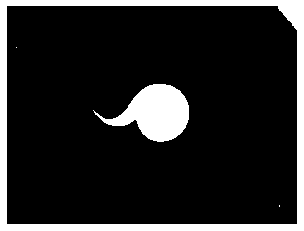

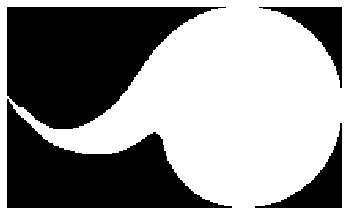

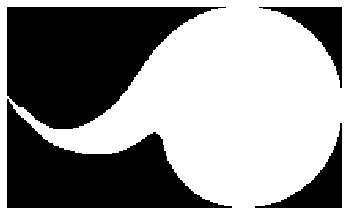

(210.57919787219151, 337.44313011828933)


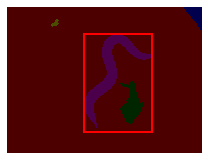

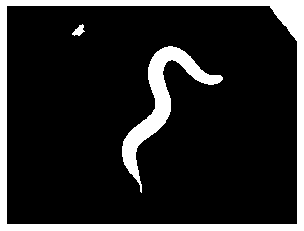

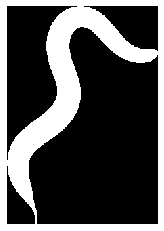

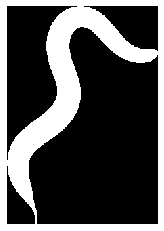

(260.6556950497626, 301.3270018864242)


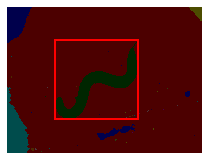

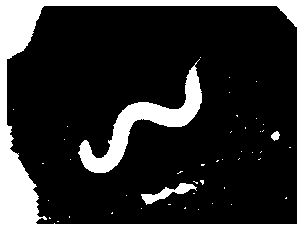

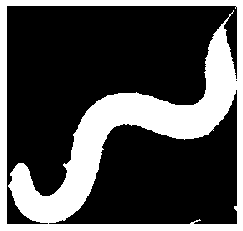

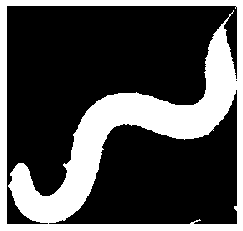

(236.56721068249257, 309.29243323442137)


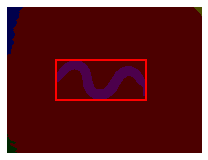

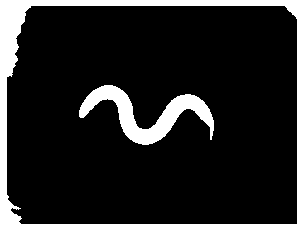

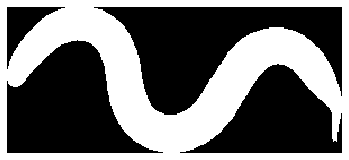

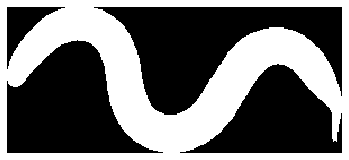

(217.95407742998353, 321.08003844041735)


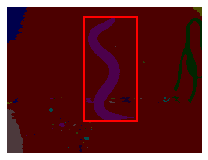

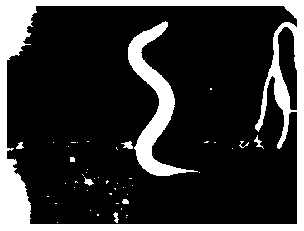

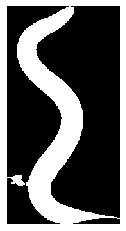

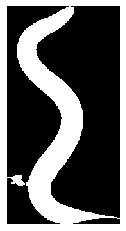

'    print("sum:", sum(sum(labeled_img)))\n    print("min, max:", dilated.shape, minr, minc, maxr, maxc)\n    print("minc, maxc:", 0, minc, maxc, dilated.shape[1])\n    print("minr, maxr:", 0, minr, maxr, dilated.shape[0])\n    print("replaced:", sum(sum(np.where(labeled_img > 0, 0, labeled_img))))\n'

In [55]:
def get_largest_region(regions):
    tmp_area = 0
    for region in regions:
        tmp_area = max(region.area, tmp_area)
    for region in regions:
        if tmp_area == region.area:
            return region

def check_whether_on_edge(img, labeled_img, region):
    minr, minc, maxr, maxc = region.bbox

    # region.bbox is around edges.
    if minr < 10 or minc < 10 or maxr > img.shape[0] - 10 or maxc > img.shape[1] - 10:
        labeled_img = np.where(labeled_img > 0 , 0, labeled_img)

    return labeled_img

def delete_obect_in_largest_region(img, largest_region, regions):

    for region in regions:

        if region != largest_region:

            lminr, lminc, lmaxr, lmaxc = largest_region.bbox
            minr, minc, maxr, maxc = region.bbox

            if minr > lminr and minc > lminc and maxr < lmaxr and maxc < lmaxc:
                labeled_img = img[minr:maxr, minc:maxc]
                img[minr:maxr, minc:maxc] = np.where(labeled_img > 0 , 0, labeled_img)

    return img

for img_path in sample_img_path:
    img = data.imread(img_path)
    img_sob, img_gray, img_bin, dilated = img_preprocessing(img)

    # label image regions
    label_image = label(dilated)
    image_label_overlay = label2rgb(label_image, image=dilated)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(image_label_overlay)

    # take regions with largest enough areas
    regions = regionprops(label_image)
    region = get_largest_region(regions)

    # draw rectangle around segmented coins
    print(region.centroid)
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                            fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

    replaced_img = delete_obect_in_largest_region(dilated, region, regions)
    plt.imshow(replaced_img)
    plt.axis("off")
    plt.show()

    labeled_img = replaced_img[minr:maxr,minc:maxc]
    plt.imshow(labeled_img)
    plt.axis("off")
    plt.show()

    edge_img = detect_celegans(img, labeled_img, region)
    plt.imshow(edge_img)
    plt.axis("off")
    plt.show()


"""    print("sum:", sum(sum(labeled_img)))
    print("min, max:", dilated.shape, minr, minc, maxr, maxc)
    print("minc, maxc:", 0, minc, maxc, dilated.shape[1])
    print("minr, maxr:", 0, minr, maxr, dilated.shape[0])
    print("replaced:", sum(sum(np.where(labeled_img > 0, 0, labeled_img))))
"""

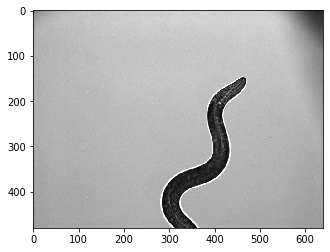

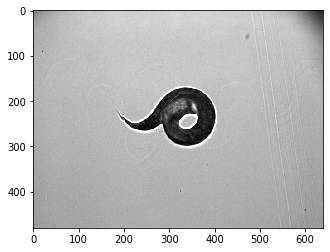

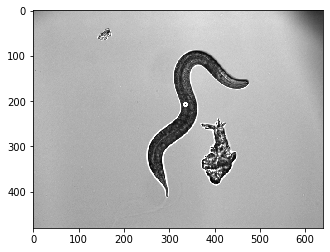

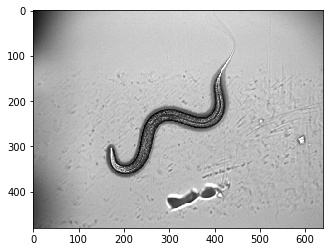

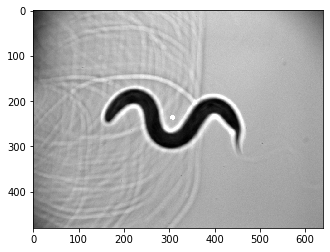

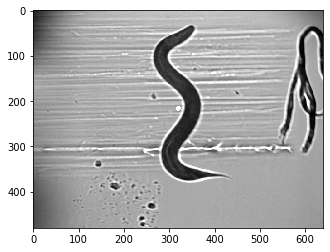

In [29]:
for img_path in sample_img_path:
    img = data.imread(img_path)
    plt.imshow(img)
    plt.show()

# 回転


In [28]:
type(padded_img[0][0])

numpy.int32

In [27]:
img_ls[0]

'F:\\Tanimoto_eLife_Fig3B\\201302111435/main\\img0.bmp'

In [7]:
# convert command
# jupyter nbconvert --to html visualize_train_images.ipynb